<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1">Overview</a></span></li><li><span><a href="#Shared-functions-and-imports" data-toc-modified-id="Shared-functions-and-imports-2">Shared functions and imports</a></span></li><li><span><a href="#K-medoids" data-toc-modified-id="K-medoids-3">K-medoids</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-3.1">Implementation</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-3.2">Tests</a></span><ul class="toc-item"><li><span><a href="#Testing-different-values-of-K" data-toc-modified-id="Testing-different-values-of-K-3.2.1">Testing different values of K</a></span></li><li><span><a href="#Testing-different-starting-medoids" data-toc-modified-id="Testing-different-starting-medoids-3.2.2">Testing different starting medoids</a></span></li></ul></li></ul></li><li><span><a href="#K-means" data-toc-modified-id="K-means-4">K-means</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-4.1">Implementation</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-4.2">Tests</a></span><ul class="toc-item"><li><span><a href="#Testing-different-values-of-K" data-toc-modified-id="Testing-different-values-of-K-4.2.1">Testing different values of K</a></span></li><li><span><a href="#Testing-different-starting-centroids" data-toc-modified-id="Testing-different-starting-centroids-4.2.2">Testing different starting centroids</a></span></li></ul></li></ul></li></ul></div>

# Overview

This notebook contains code for an implementation of the K-medoids and K-means algorithms, as well as automated performance testing of each algorithm.

# Shared functions and imports

In [1]:
# Imports
import numpy as np
from scipy.spatial import distance
from PIL import Image
import matplotlib.pyplot as plt
import random
import time
import pandas as pd

In [2]:
def get_image_pixels(path):
    """Read an image file and convert to an array of RGB pixels."""
    img = Image.open(path)  # Open the image
    img_array = np.array(img)  # Turn the image into a numpy array
    
    # Reshape image into a 2-D matrix
    img_shape = img_array.shape
    img_2d_array = np.reshape(img_array, newshape=(img_shape[0]*img_shape[1], img_shape[2]), order='C')

    return img_2d_array

In [3]:
def initialize_centers(K, data):
    """Randomly select K points from the data as cluster representatives."""
    unique_points = np.unique(data, axis=0)
    return unique_points[np.random.choice(unique_points.shape[0], K, replace=False)]

In [4]:
def assign_clusters(dissimilarities):
    """Compute an assignment array of shape from a dissimilarity matrix.
    
    Each element of the assignment array corresponds to one data point, with its value equal to the assigned cluster.
    """
    return np.argmin(dissimilarities, axis=1)  # Return index of minimum dissimilarity by row 

In [5]:
def has_converged(old_centers, new_centers):
    """Check if the value of the old centers is different from the value of the new centers."""
    return set([tuple(mu) for mu in old_centers]) == set([tuple(mu) for mu in new_centers])

In [6]:
def image_cluster(centers, labels, path):
    """Generate a clusterized representation of an image and convert it to a 3-D matrix."""
    img_clustered = np.array([centers[i] for i in labels])  # Form pixel array based only on medoids

    # Reshape pixel array into a 3-D matrix that matches the original image's dimensions
    img_original_3d = np.array(Image.open(path))
    r, c, l = img_original_3d.shape
    
    img_clustered_3d = np.reshape(img_clustered, (r, c, l), order="C")
    
    return img_original_3d, img_clustered_3d

In [7]:
def display_image(array):
    """Display a 3-D pixel matrix as an image."""
    array = array.astype(dtype='uint8')
    img = Image.fromarray(array, 'RGB')
    plt.imshow(np.asarray(img))

# K-medoids

## Implementation

The only difference between K-medoids and K-means is the method used to update cluster representatives.

In [8]:
def update_medoids(K, data, medoids, labels, metric):
    """Recalculate the center of each cluster (the medoids).
    
    1. Calculate the average dissimilarity of each point to all other points in the cluster
    2. Replace the old medoid if the current point has a lower average dissimilarity
    """
    def chunks(array, chunk_size):
        """Breaks up a NumPy array into manageable chunks to prevent out-of-memory errors."""    
        for i in range(0, len(array), chunk_size):
            yield array[i:i+chunk_size, :]

    
    new_medoids = medoids.copy()

    for k in range(K):
        cluster_data = data[labels == k, :]  # Only check points within the current cluster
        
        # Compress matrix for efficiency
        cluster_unique, return_counts = np.unique(cluster_data, axis=0, return_counts=True)

        # Calculate mean distance from medoid k to all other points
        cur_center_2d = np.reshape(new_medoids[k, :], (1, new_medoids[k, :].shape[0]))  # Reshape to a 2-D array for cdist
        cur_cost = np.mean(distance.cdist(cur_center_2d, cluster_data, metric=metric))

        # Iterate through chunks of the cluster in order to limit memory consumption
        chunk_size = 5000

        for data_chunk in chunks(cluster_unique, chunk_size):                
            # For each chunk, generate the matrix for distance from all other within-cluster points
            # Multiple distance metrics by return_count to get accurate total distance
            pairwise_distances = distance.cdist(data_chunk, cluster_unique, metric=metric) * return_counts
            average_distances = np.sum(pairwise_distances, axis=1) / np.sum(return_counts)  # Find the cost (average distance)
            
            # Pick the point with the lowest average within-cluster distance and make it the new center
            lowest_cost = np.min(average_distances)
            lowest_cost_point = np.argmin(average_distances)
            
            if lowest_cost < cur_cost:
                new_medoids[k, :] = data_chunk[lowest_cost_point, :]
                cur_cost = lowest_cost

    return new_medoids

In [26]:
def kmedoids(K, data, starting_medoids=None, max_steps=np.inf, metric='euclidean'):
    """Forms K clusters from an input dataset using the K-medoids algorithm."""
    if starting_medoids is None:
        medoids = initialize_centers(K, data)
    else:        
        assert(starting_medoids.shape[0] == K and starting_medoids.shape[1] == data.shape[1])  # Verify that shape is OK
        medoids = starting_medoids       

    converged = False
    labels = np.zeros(len(data))
    iteration = 0
    while (not converged) and (iteration < max_steps):
        old_medoids = medoids

        # Calculate dissimilarities
        dissimilarities = distance.cdist(data, old_medoids, metric)

        # Assign labels
        labels = assign_clusters(dissimilarities)

        # Update medoids
        medoids = update_medoids(K, data, old_medoids, labels, metric)

        # Check for convergence
        converged = has_converged(old_medoids, medoids)

        iteration += 1

    return labels, medoids, iteration

## Tests

In [27]:
random.seed(503)

pixels = get_image_pixels('image.bmp')  # Get 2-D matrix of pixels as input for clustering function
kmedoids_start_time = time.time()
labels, medoids, iterations = kmedoids(10, pixels)
kmedoids_end_time = time.time()
print(f"Total time: {kmedoids_end_time - kmedoids_start_time} seconds")

Total time: 99.23605465888977 seconds


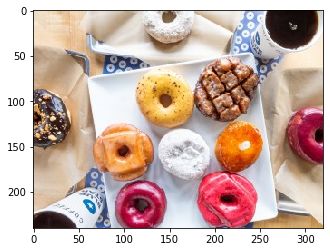

In [28]:
original_image, clusterized_image = image_cluster(medoids, labels, 'image.bmp')
display_image(original_image)

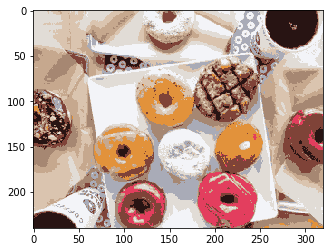

In [29]:
display_image(clusterized_image)

### Testing different values of K

In [17]:
kmedoids_results = pd.DataFrame(columns=['metric',
                                         'K',
                                         'iterations',
                                         'duration_seconds']).astype({'metric': 'category',
                                                                      'K': 'int32',
                                                                      'iterations': 'int32',
                                                                      'duration_seconds': 'int32'})

In [18]:
for metric in ['euclidean', 'sqeuclidean']:
    for K in [2, 3, 5, 10, 25, 100]:
        kmedoids_start_time = time.time()
        labels, medoids, iterations = kmedoids(K, pixels, metric=metric)
        kmedoids_end_time = time.time()
        kmedoids_results = kmedoids_results.append({'metric': metric,
                                                    'K': K,
                                                    'iterations': iterations,
                                                    'duration_seconds': kmedoids_end_time - kmedoids_start_time},
                                                   ignore_index=True)

In [19]:
kmedoids_results

,metric,K,iterations,duration_seconds
0,euclidean,2,9,163.901518
1,euclidean,3,17,247.745708
2,euclidean,5,16,138.765877
3,euclidean,10,10,38.582132
4,euclidean,25,20,29.953414
5,euclidean,100,14,6.817417
6,sqeuclidean,2,4,57.954643
7,sqeuclidean,3,10,107.913629
8,sqeuclidean,5,8,55.527849
9,sqeuclidean,10,16,52.630149


### Testing different starting medoids

In [31]:
pixels = get_image_pixels('image.bmp')  # Get 2-D matrix of pixels as input for clustering function
kmedoids_start_time = time.time()
labels, medoids, iterations = kmedoids(10, pixels, starting_medoids=np.array([[0,0,0],
                                                                             [25, 25, 25],
                                                                             [50, 50, 50],
                                                                             [75, 75, 75],
                                                                             [100, 100, 100],
                                                                             [125, 125, 125],
                                                                             [150, 150, 150],
                                                                             [175, 175, 175],
                                                                             [200, 200, 200],
                                                                             [225, 225, 225]]))
kmedoids_end_time = time.time()
print(f"Total time: {kmedoids_end_time - kmedoids_start_time} seconds")

Total time: 119.58821368217468 seconds


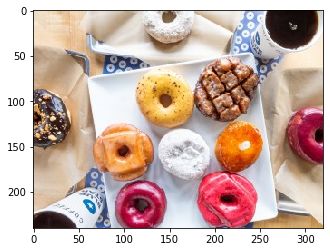

In [32]:
original_image, clusterized_image = image_cluster(medoids, labels, 'image.bmp')
display_image(original_image)

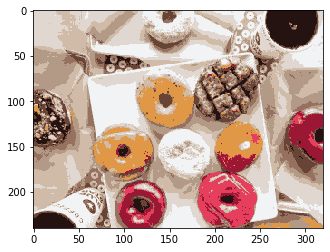

In [33]:
display_image(clusterized_image)

# K-means

## Implementation

In [34]:
def update_centroids(K, data, labels):
    """Recalculate the center of each cluster by taking the mean of all points assigned to the cluster."""

    N, d = data.shape

    centroids = np.empty((K, d))

    for k in range(K):
        # Filter the labels array (identify indices where the label == current cluster k)
        # Filter the data array by those indices and take the mean by column (axis 0)
        centroids[k, :] = np.mean(data[labels == k], axis=0)

    return centroids

In [45]:
def kmeans(K, data, starting_centroids=None, max_steps=np.inf):
    """Forms K clusters from an input dataset using the K-means algorithm."""
    if starting_centroids is None:
        centroids = initialize_centers(K, data)        
    else:
        assert(starting_centroids.shape[0] == K and starting_centroids.shape[1] == data.shape[1])  # Verify that shape is OK
        centroids = starting_centroids

    converged = False
    labels = np.zeros(len(data))
    iteration = 1
    while (not converged) and (iteration <= max_steps):
        old_centroids = centroids

        # Calculate dissimilarities using squared Euclidean distance (squared L2 norm)
        dissimilarities = distance.cdist(data, old_centroids, metric='sqeuclidean')

        # Assign labels
        labels = assign_clusters(dissimilarities)

        # Update centroids
        centroids = update_centroids(K, data, labels)

        # Check for convergence
        converged = has_converged(old_centroids, centroids)

        iteration += 1

    return labels, centroids, iteration

## Tests

In [39]:
random.seed(503)

pixels = get_image_pixels('image.bmp')  # Get 2-D matrix of pixels as input for clustering function
kmeans_start_time = time.time()
labels, centroids, iterations = kmeans(10, pixels)
kmeans_end_time = time.time()
print(f"Total time: {kmeans_end_time - kmeans_start_time} seconds")

Total time: 0.6462702751159668 seconds


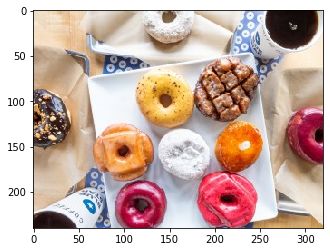

In [40]:
original_image, clusterized_image = image_cluster(centroids, labels, 'image.bmp')
display_image(original_image)

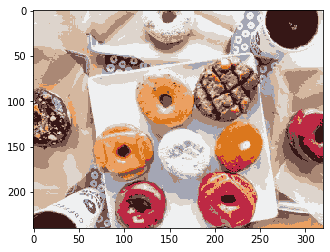

In [41]:
display_image(clusterized_image)

### Testing different values of K

In [42]:
kmeans_results = pd.DataFrame(columns=['K', 'iterations', 'duration_seconds']).astype('int32')

In [43]:
for K in [2, 3, 5, 10, 25, 100]:
    kmeans_start_time = time.time()
    labels, centroids, iterations = kmeans(K, pixels)
    kmeans_end_time = time.time()
    kmeans_results = kmeans_results.append({'K': K,
                                            'iterations': iterations,
                                            'duration_seconds': kmeans_end_time - kmeans_start_time},
                                           ignore_index=True)

In [44]:
kmeans_results

,K,iterations,duration_seconds
0,2.0,19.0,0.132674
1,3.0,32.0,0.222400
2,5.0,101.0,0.804815
3,10.0,67.0,0.845716
4,25.0,100.0,2.425536
5,100.0,161.0,13.042674


### Testing different starting centroids

In [46]:
pixels = get_image_pixels('image.bmp')  # Get 2-D matrix of pixels as input for clustering function
kmeans_start_time = time.time()
labels, centroids, iterations = kmeans(10, pixels, starting_centroids=np.array([[0,0,0],
                                                                               [25, 25, 25],
                                                                               [50, 50, 50],
                                                                               [75, 75, 75],
                                                                               [100, 100, 100],
                                                                               [125, 125, 125],
                                                                               [150, 150, 150],
                                                                               [175, 175, 175],
                                                                               [200, 200, 200],
                                                                               [225, 225, 225]]))
kmeans_end_time = time.time()
print(f"Total time: {kmeans_end_time - kmeans_start_time} seconds")

Total time: 0.7889482975006104 seconds


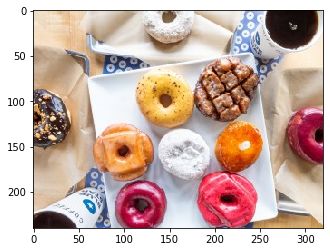

In [47]:
original_image, clusterized_image = image_cluster(centroids, labels, 'image.bmp')
display_image(original_image)

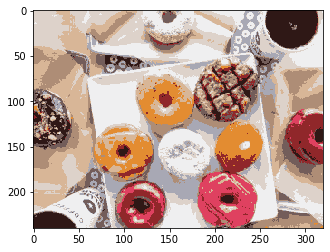

In [48]:
display_image(clusterized_image)